In [1]:
#from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import math
import pims
import trackpy as tp

# change the following to %matplotlib notebook for interactive plotting

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

@pims.pipeline
def gray_inverted(image):
    image=image[:, :, 1]
    image= zero_image(image,130)
    return image

@pims.pipeline
def gray(image):
    return image[:, :, 1]


def zero_image(image, threshold):
    for row in range(len(image)):
        row1 = image[row,:]   
        row1[row1 < threshold] =0
        image[row,:] = row1
    
    return image
def acquire_video(path, inverted=False):
    if inverted:    
        return gray_inverted(pims.open(path))
    else:
        return gray(pims.open(path))
	
def annotate_video(v, t2):
    for i in range(len(v)):
        plt.figure()
        plt.title("Image:" + str(i))
        tp.annotate(t2[t2['frame'] == i], v[i])

def plots(v):
	f = tp.locate(v[0], 5, invert=False )
	#tp.annotate(f, v[10])

	fig, ax = plt.subplots()
	ax.hist(f['mass'], bins=20)
	plt.show()
	# Optionally, label the axes.
	ax.set(xlabel='mass', ylabel='count');
	tp.subpx_bias(f)
	tp.subpx_bias(tp.locate(v[0], 5, invert=False, minmass=20));	
	plt.show()

def mainflow(
		video_path, size=5, memory=3,
		min_mass=25, max_size=2.6, max_ecc=0.3,
        invertColor=True, fractionExistInFrames=1//8,
        maximum_displacement_between_frames = 5,
		annotate=True, plots=False, return_t2_early=True
	):
    v = acquire_video(video_path, invertColor)
    #for n, i in enumerate(v):
        #v[n] = zero_image(i,220)
    #print(v)
    #print(len(v))
    frame_cnt = len(v)-3
    
    
    #size = 5 # estimated size of the features in pixels (must be an odd integer)
    f = tp.batch(v[:frame_cnt], size, minmass=min_mass, invert=invertColor, processes=1)	

    #maximum_displacement_between_frames = 5 # the larger, the slower the computation
    memory = 3 # the amount of frames that a particle can "disappear" between appearances
    t = tp.link(f, maximum_displacement_between_frames, memory=memory) # f, displacement in pixels, memory is number of frames backwards incase particle slips out of sight
    
    t.head()
    
    t1 = tp.filter_stubs(t, len(v)*fractionExistInFrames)
    print('Before:', t['particle'].nunique())
    print('After:', t1['particle'].nunique())
    print("\n\nt1:\n\n", t1)
    if plots:
        plt.figure()
        tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

    #min_mass = 25
    #max_size = 2.6
    #max_ecc = 0.3

    t2 = t1[
            ((t1['mass'] > min_mass) & 
            (t1['size'] < max_size) &
            (t1['ecc'] < max_ecc))
            ]
    print("\n\nt2:\n\n", t2)
    if return_t2_early:
        return v, t2, 0, 0, 0
    if annotate:
        frame = 1
        plt.figure()
        plt.title("Image:" + str(frame))
        tp.annotate(t2[t2['frame'] == frame], v[frame])


    d = tp.compute_drift(t2)
    tm = tp.subtract_drift(t2.copy(), d)
    #print("tm", tm)
    if plots:
        d.plot()
        ax = tp.plot_traj(tm)
    #print("tm:", tm)
    #im = tp.imsd(tm, 100/285., 24)  # microns per pixel = 100/285., frames per second = 24
    v_fps = pims.open(video_path)
    fps = v_fps.frame_rate

    mpp = 10000/2048 # from pco camera calculation from a conversation with Dr. Tanner 

    em = tp.emsd(tm, mpp, fps) # microns per pixel = 100/285., frames per second = 24
    #print("em:", em)
    tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
    if plots:

        fig, ax = plt.subplots()
        ax.plot(em.index, em, 'o')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
            xlabel='lag time $t$')
        ax.set(ylim=(1e-2, 10));
        plt.show()

        plt.figure()
        plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
        plt.xlabel('lag time $t$');
        
    # this is single plot if plot=False
    df = tp.utils.fit_powerlaw(em)
    n = df.iloc[0,0]
    A = df.iloc[0,1]
    print('\npower-law exponent, n:',n, 'A:', A, 'um^2$/s', '\n')

    # in water, a viscous material, the expected power-law exponent n=1. 
    # The value of A = 4D, where D is the particles' diffusivity. 
    # D = k_b*T/(6 * math.PI() * viscosity * radius) # Stokes-Einstein equation
    D = A / 4
    print("Diffusivity =", D, 'um^2/s = ', D*1E-12, 'm^s/s\n')
    return v, t2, n, A, D

"""
	# Original Tests
	mpp = 10000/2048
	# second_col/(4*lag time)
	# second_col = microns^2
	data = tp.motion.imsd(t2, mpp, 0.983)
	#print(data)

	particle_number = 9
	microns_sq = np.vstack(data[particle_number])[:,0]
	#print(microns_sq)
	#data heads are the particle number assigned above

	#print(data.columns.values)
	#print(data.head())

	data[particle_number].to_csv("test.csv")
	array = np.genfromtxt('test.csv', skip_header=1, delimiter=',')
	#print(array)
	lag_time = array[:,0]
	microns_sq = array[:,1]
	#print(microns_sq)
	#print(lag_time)

	dif_co = microns_sq[-1] / (4*lag_time[-1])

	dif_co_m_sq_per_s = dif_co * (1E-6**2)
	print(dif_co_m_sq_per_s)
"""

/Users/austinwallace/miniconda3/envs/qforte_env/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


'\n\t# Original Tests\n\tmpp = 10000/2048\n\t# second_col/(4*lag time)\n\t# second_col = microns^2\n\tdata = tp.motion.imsd(t2, mpp, 0.983)\n\t#print(data)\n\n\tparticle_number = 9\n\tmicrons_sq = np.vstack(data[particle_number])[:,0]\n\t#print(microns_sq)\n\t#data heads are the particle number assigned above\n\n\t#print(data.columns.values)\n\t#print(data.head())\n\n\tdata[particle_number].to_csv("test.csv")\n\tarray = np.genfromtxt(\'test.csv\', skip_header=1, delimiter=\',\')\n\t#print(array)\n\tlag_time = array[:,0]\n\tmicrons_sq = array[:,1]\n\t#print(microns_sq)\n\t#print(lag_time)\n\n\tdif_co = microns_sq[-1] / (4*lag_time[-1])\n\n\tdif_co_m_sq_per_s = dif_co * (1E-6**2)\n\tprint(dif_co_m_sq_per_s)\n'

Frame 14: 1 trajectories present.
Before: 2
After: 2


t1:

                 y           x        mass      size       ecc     signal  \
frame                                                                      
0      633.869413  559.027235  317.362344  1.754881  0.336960  28.256773   
1      631.008599  553.836976  316.809423  1.789435  0.451418  28.945325   
1      637.876889  558.265020  307.955559  1.839586  0.464922  27.242659   
2      639.976576  555.938340  349.277809  1.795908  0.376155  30.680621   
2      639.976576  555.938340  349.277809  1.795908  0.376155  30.680621   
4      639.810844  553.128007  298.254192  1.742961  0.352203  28.208305   
5      639.850102  544.967006  240.905478  1.703835  0.338501  25.022769   
6      647.042362  549.163457  254.063237  1.663240  0.338255  27.721919   
7      650.082251  550.077922  252.527041  1.693913  0.367114  25.342147   
8      647.233284  544.086181  228.115728  1.699576  0.347971  21.354073   
9      653.996854  548.3375

/Users/austinwallace/miniconda3/envs/qforte_env/lib/python3.7/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/Users/austinwallace/miniconda3/envs/qforte_env/lib/python3.7/site-packages/trackpy/motion.py:237: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


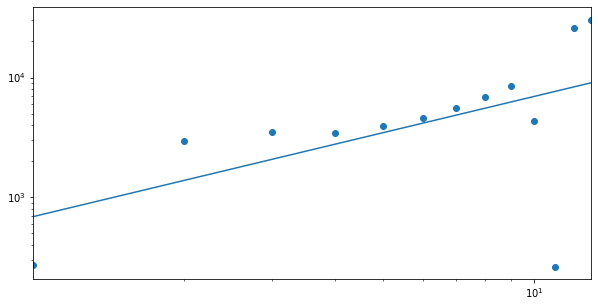

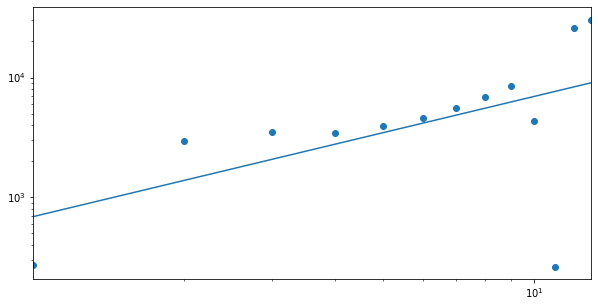


power-law exponent, n: 1.0037812568744953 A: 688.3988683887786 um^2$/s 

Diffusivity = 172.09971709719466 um^2/s =  1.7209971709719464e-10 m^s/s



In [2]:

v, t2, n, A, D = mainflow(
			video_path=r'ChitosanTPP&water.mp4', size=7, memory=10,
			min_mass=20, max_size=7, max_ecc=0.5,
			invertColor=True, fractionExistInFrames=1//8,
			maximum_displacement_between_frames = 15,
			annotate=False, plots=False, return_t2_early=False
		
)



In [ ]:
annotate_video(v, t2)

In [ ]:
plt.figure()
tp.plot_traj(t2)

In [ ]:
v, t2, n, A, D = mainflow(
		#video_path=r'ChitosanTPP&water.mp4', size=3, memory=10,
		# video_path=r'trackingvid.mp4', size=5, memory=10,
		# min_mass=20, max_size=7, max_ecc=0.5,
        # invertColor=False, fractionExistInFrames=1//8,
		# annotate=True, plots=False

		video_path=r'trackingvid.mp4', size=7, memory=10,
		min_mass=20, max_size=7, max_ecc=0.5,
		invertColor=False, fractionExistInFrames=1//8,
		maximum_displacement_between_frames = 15,
		annotate=False, plots=False, return_t2_early=False
)